<a href="https://colab.research.google.com/github/kayleefoor/Foor_DSPN_S24/blob/main/Exercise_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 13:  Resampling methods

This homework assignment is designed to give you practice with bootstrapping and permutation tests.

You will need to download the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file from the *Homework/hcp_data* folder in the class GitHub repository.

This data is a portion of the [Human Connectome Project database](http://www.humanconnectomeproject.org/). It provides measures of cognitive tasks and brain morphology measuresments from 1206 participants. The full description of each variable is provided in the **HCP_S1200_DataDictionary_April_20_2018.csv** file in the *Homework/hcp_data* folder in the class GitHub repository.

---
## 1. Loading & Visualizing the Data (1 point)

Use the `setwd` and `read.csv` functions to load data from the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file.

(a) Using the tidyverse tools, make a new dataframe `d1` that only inclues the subject ID (`Subject`), gender (`Gender`, self reported at time of data collection), Flanker Task performance (`Flanker_Unadj`), total intracranial volume (`FS_IntraCranial_Vol`), total white matter volume (`FS_Tot_WM_Vol`), and total grey matter volume (`FS_Total_GM_Vol`) variables and remove all _na_ values.

Use the `head` function to look at the first few rows of each data frame.

In [3]:
df <- read.csv("unrestricted_trimmed_1_7_2020_10_50_44.csv")

In [24]:
d1 <- subset(df[, c("Subject", "Gender", "Flanker_Unadj", "FS_IntraCranial_Vol", "FS_Tot_WM_Vol", "FS_Total_GM_Vol")])
d1 <- na.omit(d1)
head(d1)
dim(d1)

[1] 1113    6

(b) Plot grey matter volume (x axis) against intracranial volume (y axis) and Gender (point color).

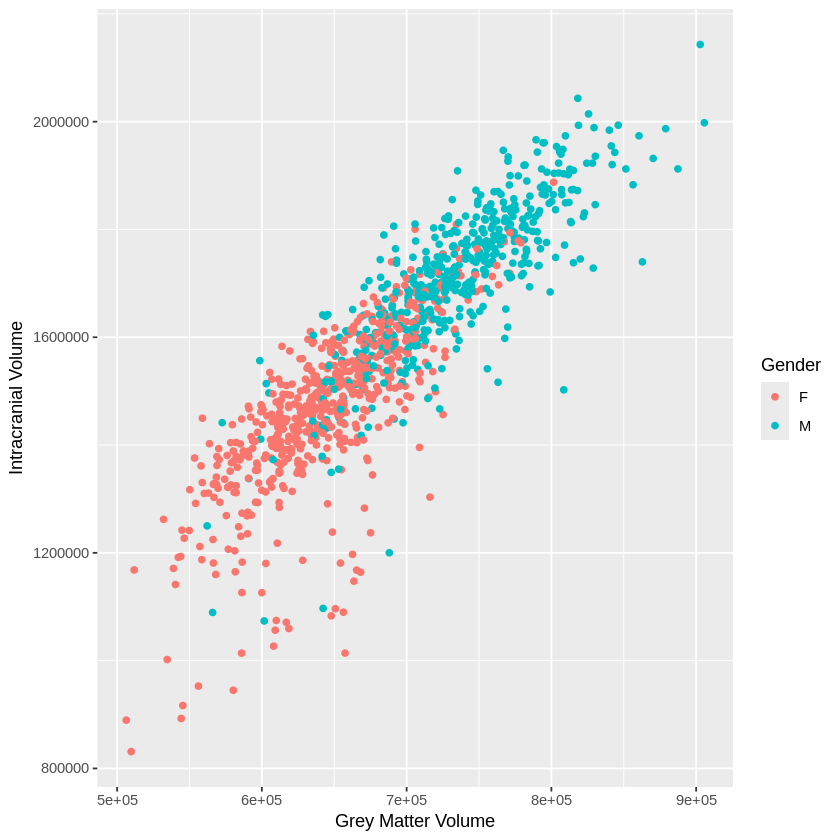

In [6]:
library(tidyverse)
ggplot(d1, aes(x = FS_Total_GM_Vol, y = FS_IntraCranial_Vol, color = Gender)) +
  geom_point() +
  labs(x = "Grey Matter Volume", y = "Intracranial Volume", color = "Gender")

What patterns do you observe in the scatter plot?

> *Broadly, there is a positive relationship between grey matter volume and intracranial volume. In particular, men tend to have greater grey matter volume than women.*
>

---
## 2. Logistic classifier (2 points)

We want to try predicting gender using the neural data you have loaded.

(a) Run a logisic regression model to predict gender from total white matter volume, total grey matter volume, and intracranial volume.

In [7]:
d1$Gender = as.factor(d1$Gender)
glm_fit <- glm(Gender~FS_Tot_WM_Vol+FS_Total_GM_Vol+FS_IntraCranial_Vol,
                data=d1, family="binomial")
summary(glm_fit)


Call:
glm(formula = Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, 
    family = "binomial", data = d1)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.262e+01  1.347e+00 -16.787  < 2e-16 ***
FS_Tot_WM_Vol        2.140e-06  3.059e-06   0.699    0.484    
FS_Total_GM_Vol      1.959e-05  3.145e-06   6.229 4.70e-10 ***
FS_IntraCranial_Vol  5.020e-06  1.177e-06   4.263 2.01e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1534.13  on 1112  degrees of freedom
Residual deviance:  919.85  on 1109  degrees of freedom
AIC: 927.85

Number of Fisher Scoring iterations: 5


Which factors are signficantly associated with gender?

> *Given the model output, it appears that grey matter volume and intracranial volume are significantly associated with gender, but white matter volume is not.*
>

(b) Estimate the prediction accuracy of your model (Note: this is the training set accuracy). Set your prediction threshold to 0.5.

In [10]:
probs <- predict(glm_fit, type = "response")
predicted_classes <- ifelse(probs > 0.5, "M", "F")
accuracy <- mean(predicted_classes == d1$Gender)
print(paste("Accuracy:", accuracy))


[1] "Accuracy: 0.820305480682839"


What is the prediction accuracy for gender from the full model?

>*The model has 82% prediction accuracy.*
>

---
## 3. Bootstrapped accuracy (3 points)

Use bootstrapping to estimate the confidence intervals of the _prediction accuracy_ of your model (i.e., the confidence of the correlation between $\hat{y}$ and $y$). Plot the histogram of the bootstrapped prediction accuracies and estimate the confidence intervals off of the standard deviation from the bootstrap.


In [11]:
install.packages("boot")
library(boot)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [12]:
accuracy_fn <- function(data, indices) {
  d <- data[indices, ]
  glm_fit <- glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol,
                 data = d, family = "binomial")
  probs <- predict(glm_fit, type = "response")
  predicted_classes <- ifelse(probs > 0.5, "M", "F")
  mean(predicted_classes == d$Gender)
}


set.seed(1)
results <- boot(data = d1, statistic = accuracy_fn, R = 1000)

[1] "Confidence interval: 0.794810933371765 0.843226802477291"


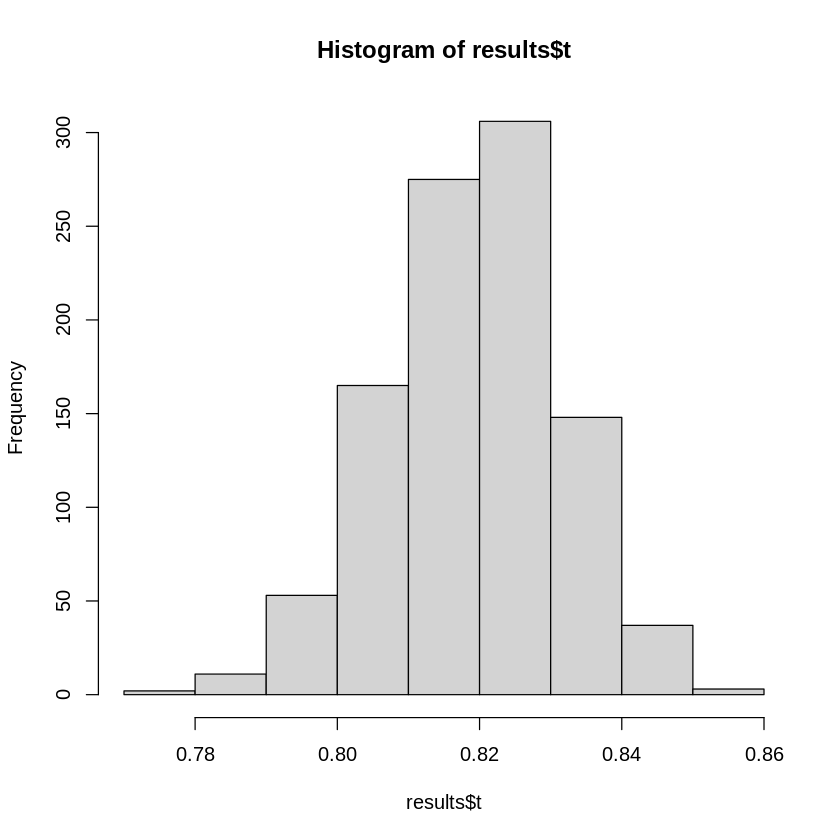

In [17]:
hist(results$t)

boot_mean <- mean(results$t)
boot_sd <- sd(results$t)
low <- boot_mean - 1.96 * boot_sd
high <- boot_mean + 1.96 * boot_sd
print(paste("Confidence interval:", low, high))

How robust is the prediction accuracy of the full model?

> *The model is normally distributed around the 82% accuracy point*
>

---
## 4. Permutation test for grey matter effects (3 points)

Now run a permutation test, with 1000 iterations, to evaluate how much grey matter volume contributes to the prediction accuracy. Compare the prediction accuracy of the full (unpermuted model) with the distribution of accuracies you get with a randomized grey matter volume term using a histogram (Hint: use the `abline` function to show the original accuracy on the histogram).

In [35]:
perm_data = d1
R=1000
perm.fit <- glm(Gender ~ FS_Tot_WM_Vol +
                          FS_Total_GM_Vol + FS_IntraCranial_Vol,
                          data = perm_data, family = "binomial")

perm.preds = matrix(NA, nrow=R, ncol=length(coef(perm.fit)))

for (i in 1:R){
  perm_data$FS_Total_GM_Vol=d1$FS_Total_GM_Vol[sample(1113)]
  perm.preds[i,]=coef(glm(Gender ~ FS_Tot_WM_Vol +
                          FS_Total_GM_Vol + FS_IntraCranial_Vol,
                          data = perm_data, family = "binomial")) }
perm.preds

perm.real = coef(glm(Gender ~ FS_Tot_WM_Vol +
                          FS_Total_GM_Vol + FS_IntraCranial_Vol,
                          data = d1, family = "binomial"))
perm.real

-19.64842,7.913557e-06,9.503595e-07,9.591983e-06
-18.00934,7.821897e-06,-1.544804e-06,9.664469e-06
-17.55272,8.033902e-06,-2.003833e-06,9.518412e-06
-19.94238,7.770987e-06,1.306501e-06,9.662299e-06
-18.35161,7.800218e-06,-1.068672e-06,9.678654e-06
-20.27092,7.810038e-06,1.734782e-06,9.673648e-06
-17.89439,7.926486e-06,-1.600368e-06,9.583451e-06
-18.45311,7.925678e-06,-8.313095e-07,9.605198e-06
-19.41038,7.877110e-06,5.855162e-07,9.610368e-06
-19.02235,7.841127e-06,3.177103e-08,9.614929e-06
-19.25021,7.837433e-06,3.435262e-07,9.624814e-06


(Intercept)       FS_Tot_WM_Vol     FS_Total_GM_Vol FS_IntraCranial_Vol 
      -2.261599e+01        2.139610e-06        1.959056e-05        5.019787e-06

[1] "P-value: 0"


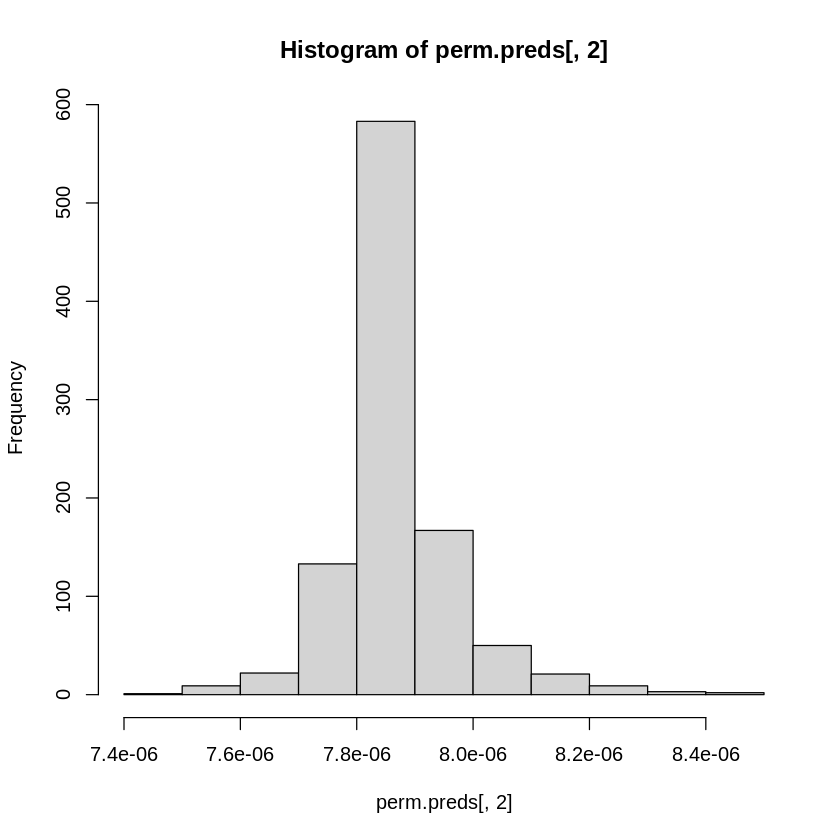

In [39]:
# Plot histogram of permuted accuracies
hist(perm.preds[,2])

# Add a vertical line for the original accuracy
abline(v = accuracy, col = "red", lwd = 2)

# Calculate p-value (proportion of permuted accuracies greater than or equal to the original accuracy)
p_value <- mean(perm.preds >= accuracy)

# Print the p-value
print(paste("P-value:", p_value))

How much does the grey matter volume influence the prediction accuracy of the model?

> *We get a value of zero for the p value, which indicates that there is no influence of grey matter volume on the prediction accuracy of the model.*
>

---
## 5. Reflection (1 point)

Differentiate the bootstrap from a permutation test. Describe each and when is it appropriate to each.

> *Bootstrapping randomly resamples the data with replacement. This type of resampling should be used for non-parametric testing when we want to estimate the uncertainty of a given statistic. Permutation testing shuffles the data while maintaining the overall structure in order to engage in targeted null hypothesis testing.*
>

**DUE:** 5pm EST, March 27, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *Someone's Name*